# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from scipy.interpolate import interp1d


# Function definitions

In [3]:
def plot_line_segment(point, slope, length):
    # Plots a line segment
    # Inputs: 
    # point = coordinates of the point in decimal degrees
    # slope = slope of the line
    # length = length of the line
    # Outputs: 
    # [x0,x2],[y0,y2] = endpoints of the line

    y1, x1 = point
    if slope==0:
        dx = 5
        dy = 0
    else:
        slope = 1/slope

        dx = length / (2 * np.sqrt(1 + slope**2))
        dy = slope * dx

    x2 = x1 + dx
    y2 = y1 + dy

    x0 = x1 - dx
    y0 = y1 - dy

    return [x0,x2],[y0,y2]

def rose_diagram(angles, bin_width):
    # Creates a histogram of concretion trends
    # Inputs: 
    # angles = concretion trends in degrees, where north=0
    # bin_width = angular width of the bins in degrees
    # Outputs: 
    # theta_symmetrical = angles of the histogram bins
    # hist_symmetrical = heights of the histogram bins

    # Define the bins
    bins = np.arange(-90, 91, bin_width)  # Bins of width 1 from -90 to 90

    # Create the histogram
    hist, edges = np.histogram(angles, bins=bins)

    # Convert bin edges to radians for polar plot
    theta_original = np.radians(edges[:-1])

    # Duplicate the data for angles greater than 90 degrees and less than -90 degrees
    theta_symmetrical = np.concatenate([theta_original, theta_original + np.pi])

    # Duplicate the histogram values
    hist_symmetrical = np.concatenate([hist, hist])
    
    return theta_symmetrical, hist_symmetrical

def haversine_distance(lat1, lon1, lat2, lon2): 
    # Calculates the great circle distance between two points on the earth, specified in decimal degrees
    # Inputs: 
    # lat1, lon1, lat2, lon2 = coordinates of the two points
    # Outputs:
    # distance between the two points, approximated using the Haversine formula
    
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    # Convert to meters
    return km * 1000

def calculate_angle(slope):
    # Calculates the angle of a line from its slope
    # Inputs: 
    # slope = slope of a line
    # Outputs: 
    # angle = angle of the line, where north=0
    if np.abs(slope)<=1e-6:
        return 0
    if slope==float('inf'):
        return 90
    dx = 1
    dy = slope
    angle = np.degrees(-np.arcsin(dy / np.sqrt(dx**2 + dy**2) )) # the minus sign makes the result agree with angle definition
    return angle

def calculate_slope(angle):
    # Calculates the slope of a line from its angle
    # Inputs: 
    # angle = angle of the line, where north=0
    # Outputs: 
    # slope = slope of the line
    if np.abs(angle) <= 1e-6:
        return 0
    if np.abs(angle - 90) <= 1e-6:
        return float('inf')
    dx = 1
    dy = np.tan(np.radians(angle))
    slope = - dy / dx
    return slope

def transform_angles(angles):
    # Converts angles from [0, 180] to [-90, 90]
    # Input: 
    # angles = angles to convert
    # Output: 
    # converted angles
    return (angles + 90) % 180 - 90

# Import data

In [ ]:
folder_path = os.getcwd()
file_name = 'RawData_v2.csv'
file_path = folder_path + '/' + file_name
image_path = folder_path + '/blank_basemap.png'

# Import data
data = pd.read_csv(file_path).values

In [5]:
lon = data[:, 1]
lat = data[:, 2]
elev = data[: ,3]
trend = data[:, 4]
elevKP = data[:, 5]
elevdiff = data[:, 6]

In [6]:
N = len(lon)
print("Number of data points: ", N)

Number of data points:  2941


# Import basemap

In [7]:
# Import basemap
basemap = plt.imread(image_path)

# Boundary coordinates of the basemap in decimal degrees
ymin = 46.999909 
xmin = -107.999379
xmax = -105.826994
ymax = 48.061238

# Make data bins

In [8]:
# Define bin edges from -100 to 100 in steps of 5
bin_edges = np.arange(-100, 105, 5)  # 105 to include 100 in the last bin

# Create bins using list comprehension
bins = [data[(data[:, 6] >= bin_edges[i]) & (data[:, 6] < bin_edges[i + 1])] for i in range(len(bin_edges) - 1)]

# Extract latitudes and longitudes for each bin
latitudes = [bin_data[:, 2] for bin_data in bins]
longitudes = [bin_data[:, 1] for bin_data in bins]

# Plot all data

In [9]:
# first, calculate the slopes from the given angles
slopes = []
for i in range(N):
  slopes.append(calculate_slope(trend[i]))

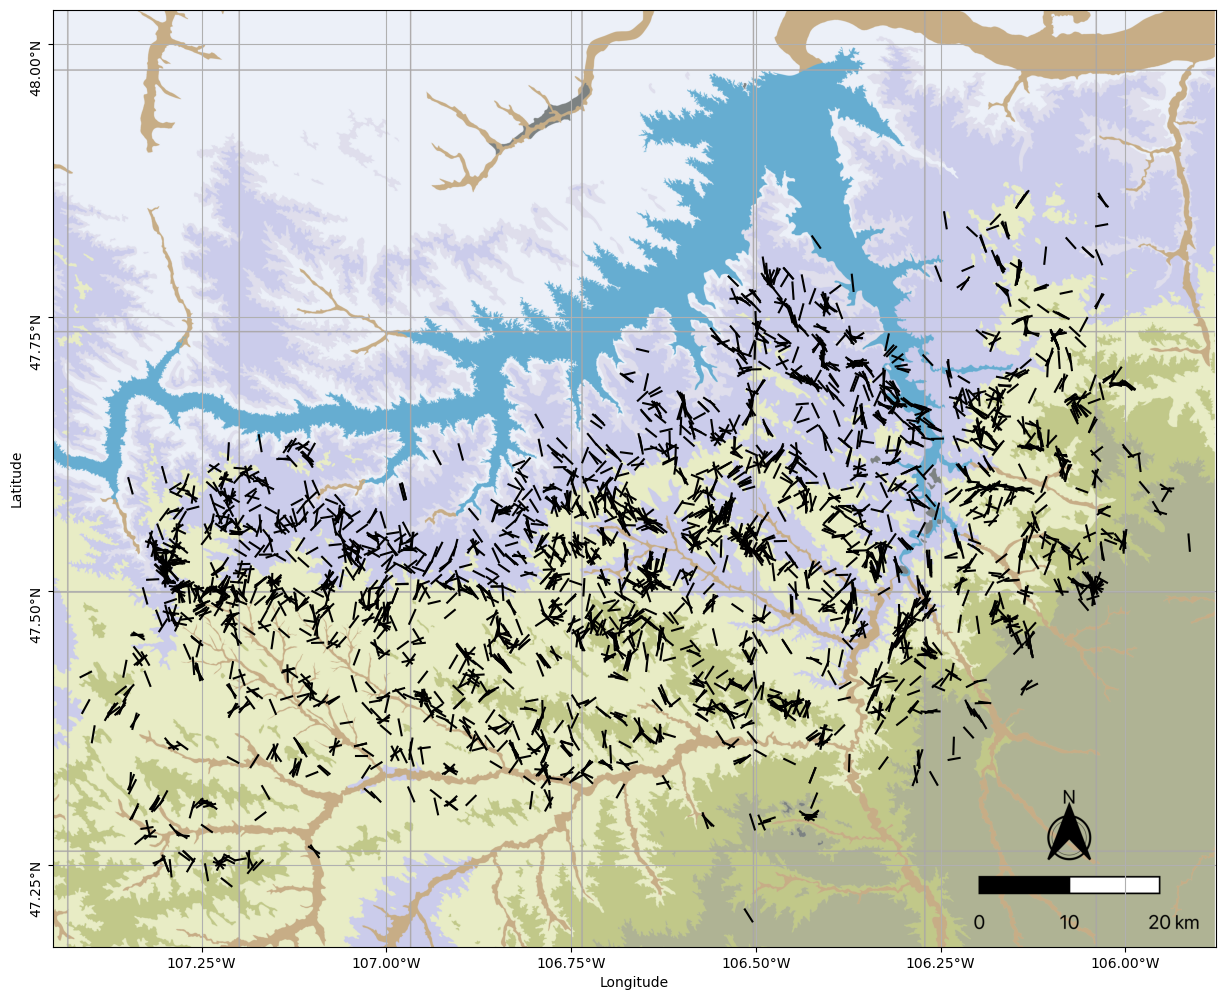

In [ ]:
aspect_ratio = 111194.92664455889/75077.92837945123 

width = 15
height = width * aspect_ratio
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, height))
ax.imshow(basemap, extent=[xmin, xmax, ymin, ymax])

# Set ticks and grid lines every 0.25° longitude and 0.25° latitude
ax.set_xticks(np.arange(xmin, xmax, 0.25)[1:])
ax.set_yticks(np.arange(ymin, ymax, 0.25))

for i in range(N):
  pix = [lat[i], lon[i]]
  slope_av = slopes[i]

  # convert angle to radians
  trend_rad = np.radians(trend[i])

  # set line length
  line_length = 0.015

  if np.abs(slope_av) < 1e-5:
    continue
  
  else:
      # Compute the start and end points of the lines
      dx = line_length * np.sin(trend_rad) / 2
      dy = line_length * np.cos(trend_rad) / 2
      x_start = lon[i] - dx
      y_start = lat[i] - dy
      x_end = lon[i] + dx
      y_end = lat[i] + dy

      # Plot the lines
      plt.plot([x_start, x_end], [y_start, y_end], color='black')

x_tick_labels = [f'{abs(x):.2f}°{"E" if x >= 0 else "W"}' for x in plt.xticks()[0]]
y_tick_labels = [f'{abs(y):.2f}°{"N" if y >= 0 else "S"}' for y in plt.yticks()[0]]
plt.gca().set_xticklabels(x_tick_labels)
plt.gca().set_yticklabels(y_tick_labels, rotation=90)

plt.xlim(-107.45, xmax-0.05)
plt.ylim(47.175, ymax-0.03)

# Set the aspect ratio of the axes
plt.gca().set_aspect(aspect_ratio)

# Set the axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plot rose diagrams for each 5-meter stratigraphic interval

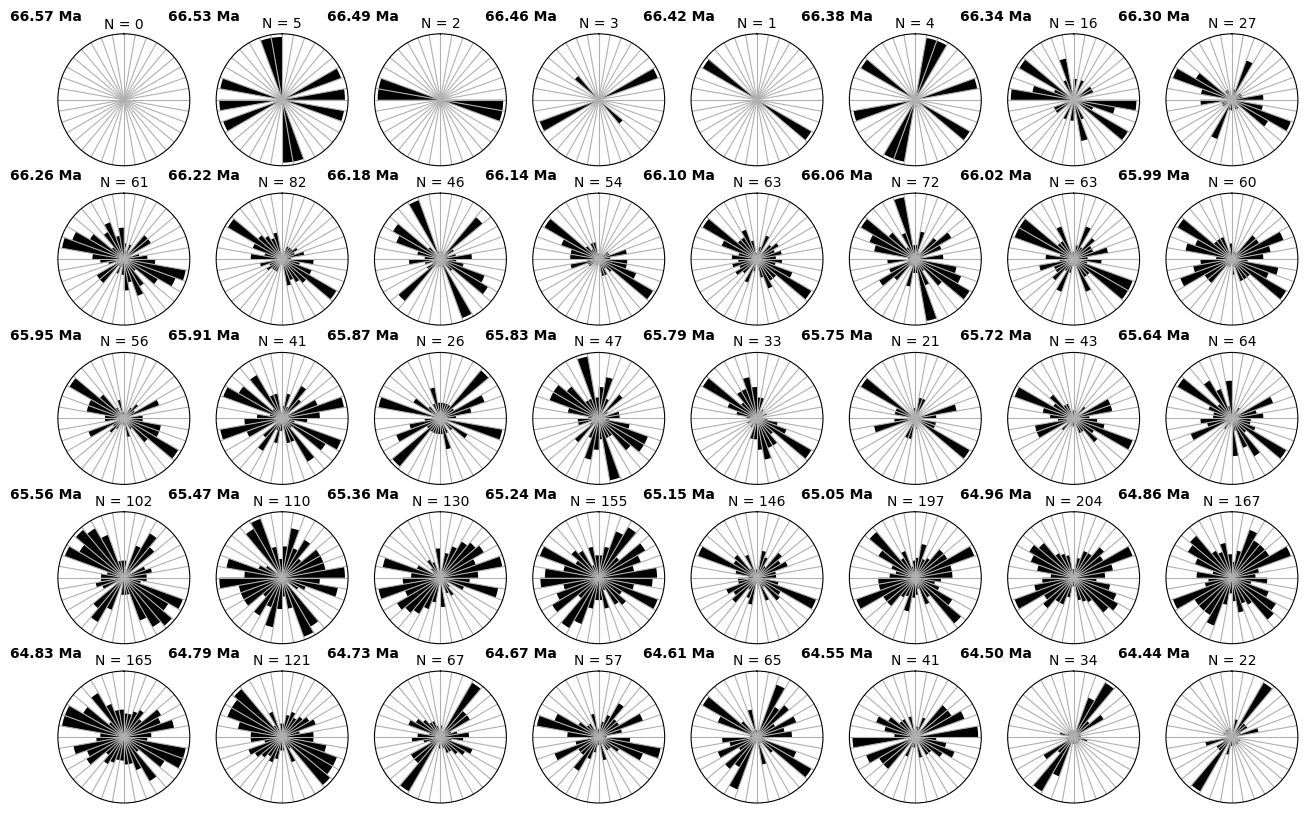

In [11]:
df = pd.read_csv('carter2025_recalculated_agemodel.csv')
stratlevel = df['elevation relative to KPB']
age = df['Carter et al. (2025) age']

# Create the interpolation function
age_interpolator = interp1d(stratlevel, age, kind='linear', fill_value="extrapolate")

age_at_stratlevel = age_interpolator(bin_edges[:-1])

rounded_ages = np.round(age_at_stratlevel, 2)

fig, axs = plt.subplots(5, 8, subplot_kw={'projection': 'polar'}, 
                        figsize=(16,10))

max_hist_value = 0

for bin_index in range(len(bins)):
    bin_data = bins[bin_index]
    if bin_data.size > 0:
        angles = transform_angles(bin_data[:, 4])
        _, hist = rose_diagram(angles, 10)
        max_hist_value = max(max_hist_value, max(hist))

rows, cols = axs.shape
positions = np.array(axs).flatten()  # Flatten the 2D array of subplots

# Second pass: Plot the rose diagrams for the selected cluster in subplots
for bin_index in range(len(bins)):
    bin_data = bins[bin_index]

    # Convert bin_index to row and column indices
    row = bin_index // cols  # Integer division for row index
    col = bin_index % cols   # Modulo for column index

    ax = axs[row, col]  # Access the correct subplot

    if len(bin_data) >= 0:
        angles = transform_angles(bin_data[:, 4])
        theta, hist = rose_diagram(angles, 10)

        # Plot the bar
        ax.bar(theta, hist, width=np.deg2rad(10), align='edge', color='black')
        ax.text(0, ax.get_ylim()[1] * 1.05,
                f"N = {len(bin_data)}", 
                ha='center', va='bottom', fontsize=10)

    else:
        # If no data, create an empty plot
        theta = np.linspace(0, 2 * np.pi, 36)
        hist = np.zeros_like(theta)
        ax.bar(theta, hist, width=np.deg2rad(10), align='edge', color='black', alpha=0.2)


    # Configure the polar plot
    ax.set_xticks(np.linspace(0, 2 * np.pi, 36, endpoint=False))
    ax.set_xticklabels([])
    #ax.set_xticklabels([f'{i}°' for i in range(0, 360, 10)])
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.radians(90))
    ax.set_yticks([])  # Set y-ticks

    age_label = f"{rounded_ages[bin_index]:.2f} Ma"  # Get the rounded age for the current bin
    x_pos = ax.get_position().x0 + 0.015
    y_pos = ax.get_position().y1 + 0.01
    fig.text(x_pos, y_pos, age_label, ha='right', va='bottom', fontsize=10, fontweight='bold')


    ax.set_facecolor("white")
    #ax.set_ylim(0, max_hist_value + 2)  # Apply consistent radial limit

# Adjust layout
plt.show()

# Apply bimodality test

Apply bimodality test with reorientation. "Reorientation" means that the data histograms are reoriented so their two tallest peaks are symmetric around 0°. This ensures the bimodality analysis is independent of the overall flow direction and is only looking at the distribution of flow directions to analyze its shape for bimodality.  

In [12]:
import sys
sys.path.append(folder_path + '/tangent and angle code')
from rose_diagram import *
from check_bimodality import *
from transform_angles import *
from closest_compass_direction import *

66.57 Ma - 66.53 Ma
<10 data points


66.53 Ma - 66.49 Ma
<10 data points


66.49 Ma - 66.46 Ma
<10 data points


66.46 Ma - 66.42 Ma
<10 data points


66.42 Ma - 66.38 Ma
<10 data points


66.38 Ma - 66.34 Ma
<10 data points


66.34 Ma - 66.30 Ma


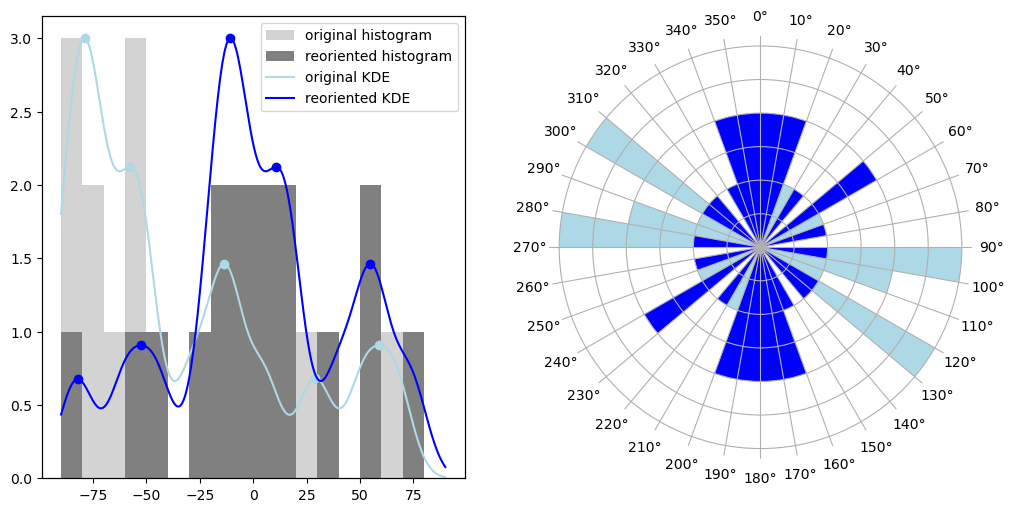

bimodality result:  False




66.30 Ma - 66.26 Ma


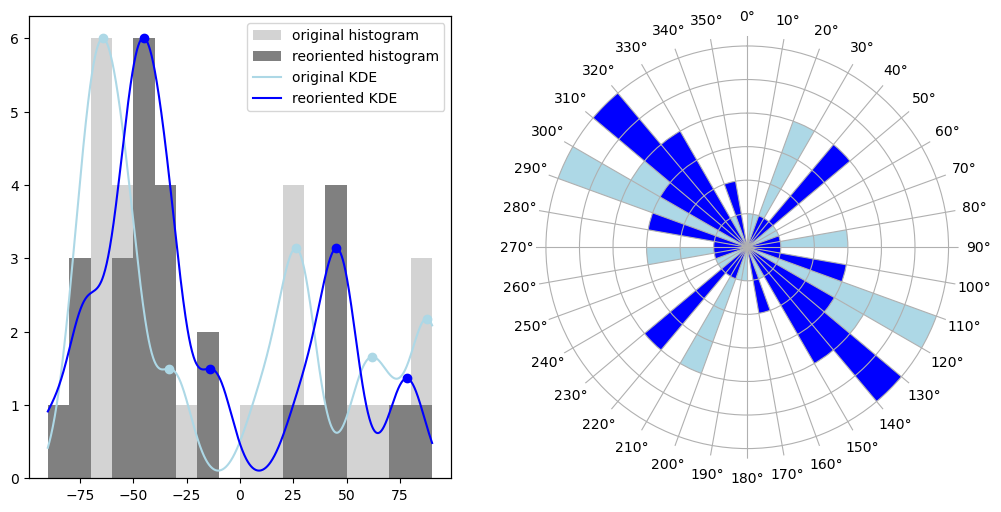

bimodality result:  True




66.26 Ma - 66.22 Ma


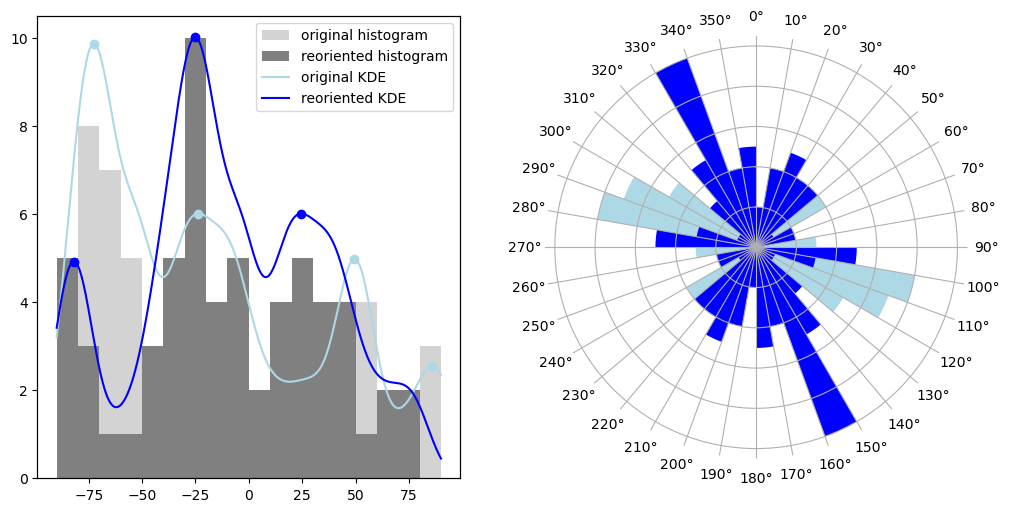

bimodality result:  False




66.22 Ma - 66.18 Ma


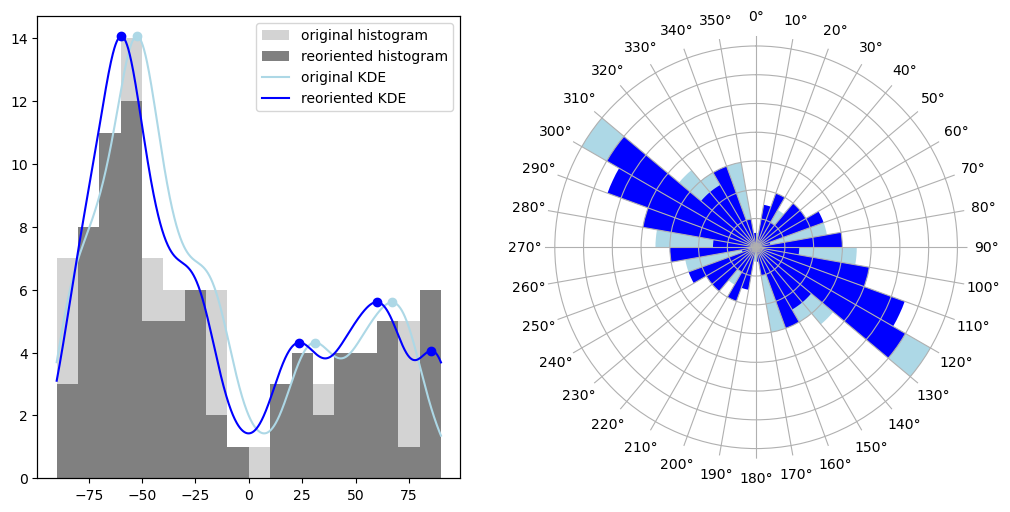

bimodality result:  False




66.18 Ma - 66.14 Ma


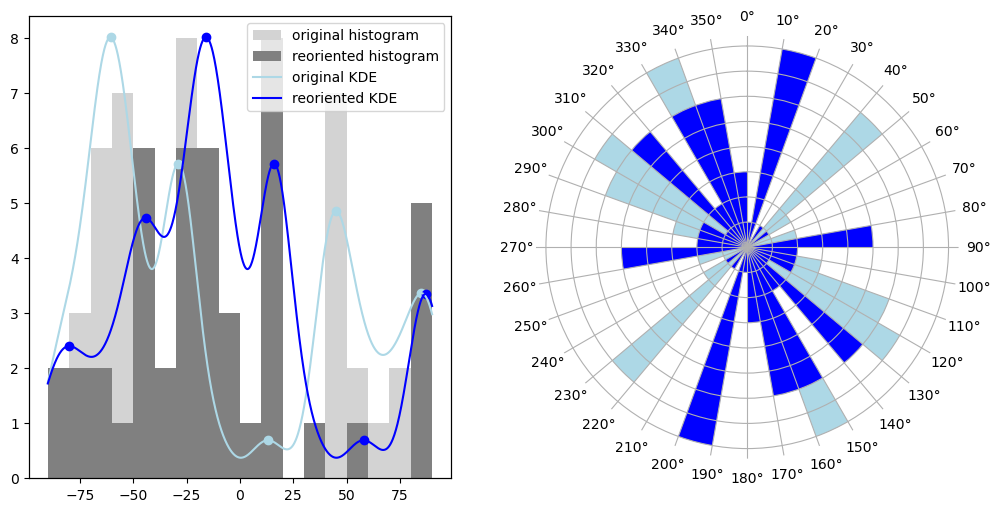

bimodality result:  False




66.14 Ma - 66.10 Ma


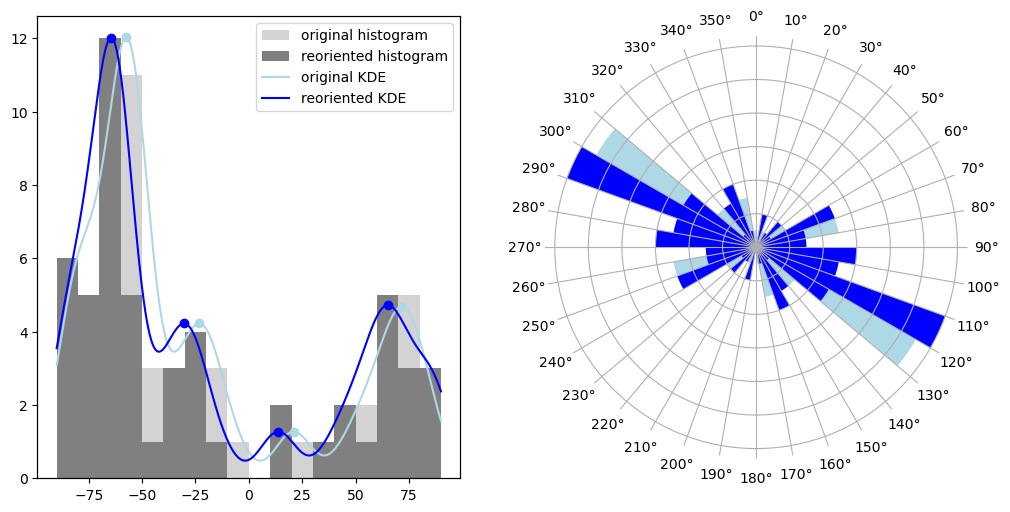

bimodality result:  False




66.10 Ma - 66.06 Ma


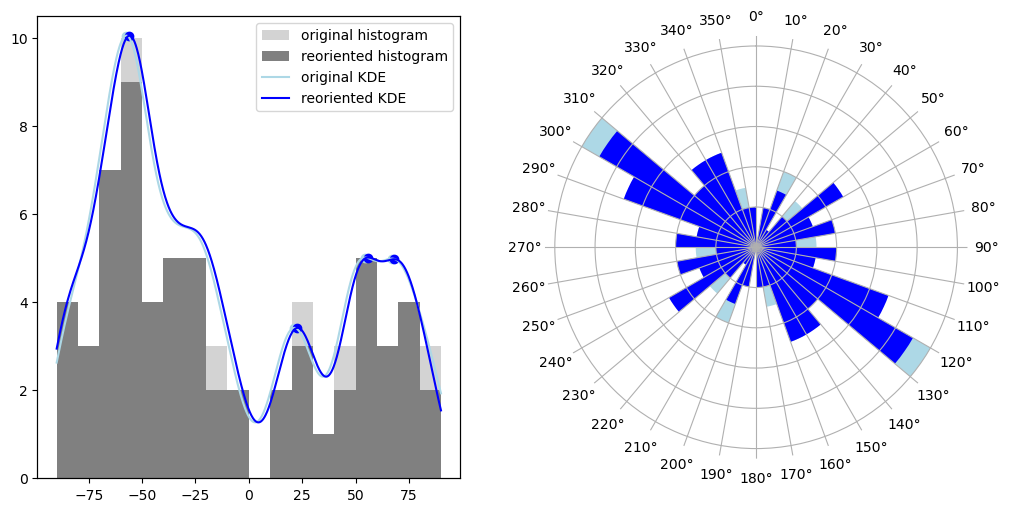

bimodality result:  False




66.06 Ma - 66.02 Ma


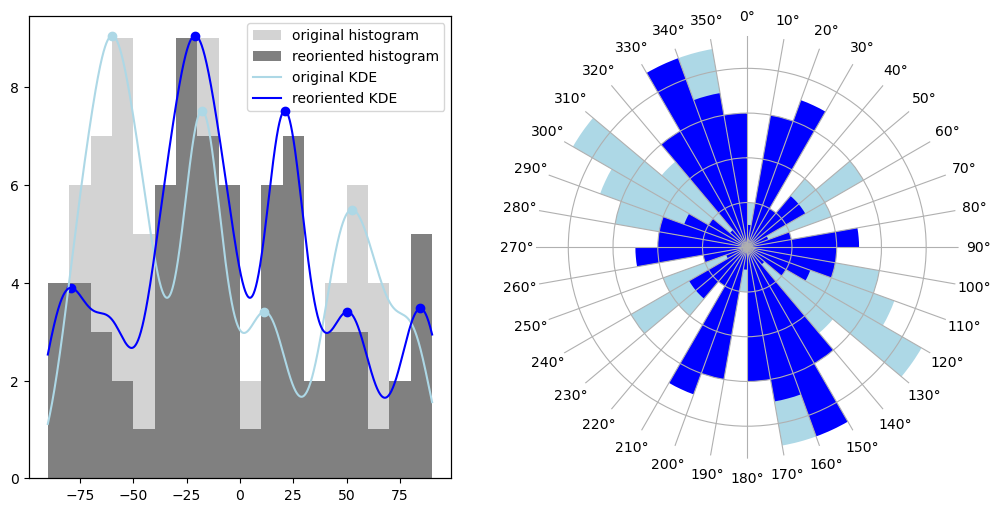

bimodality result:  False




66.02 Ma - 65.99 Ma


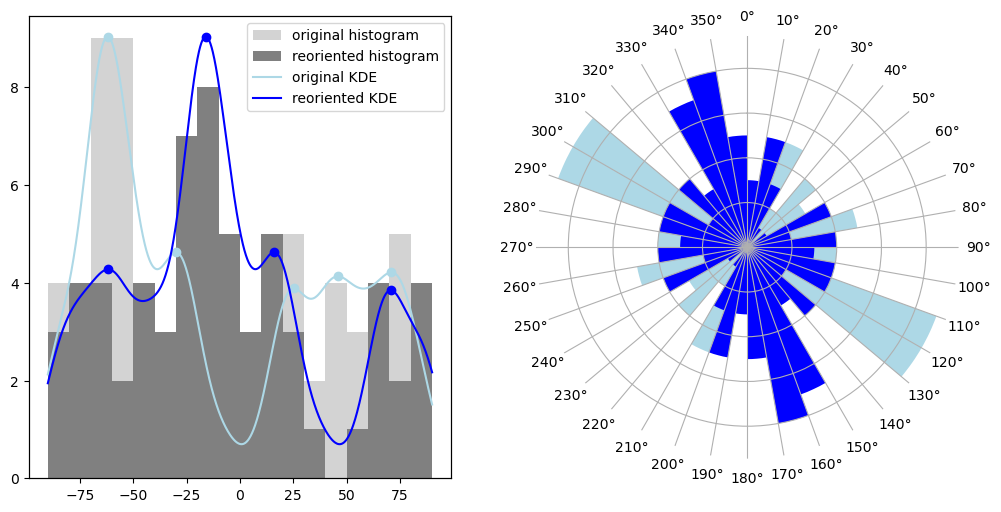

bimodality result:  False




65.99 Ma - 65.95 Ma


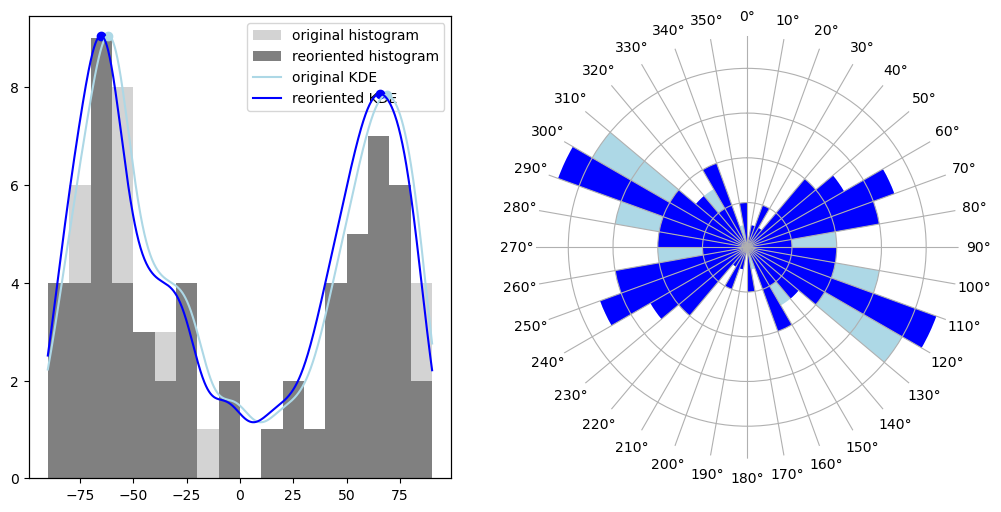

bimodality result:  True




65.95 Ma - 65.91 Ma


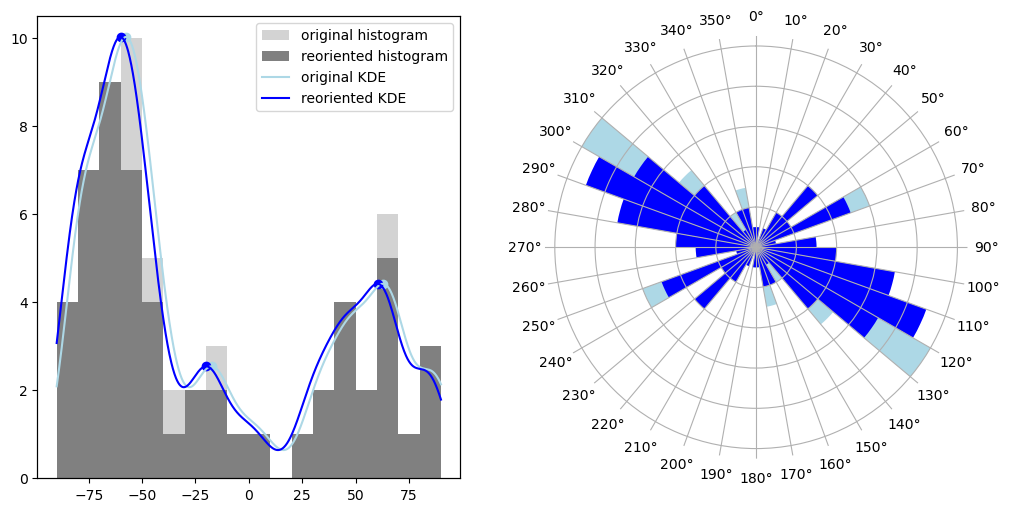

bimodality result:  False




65.91 Ma - 65.87 Ma


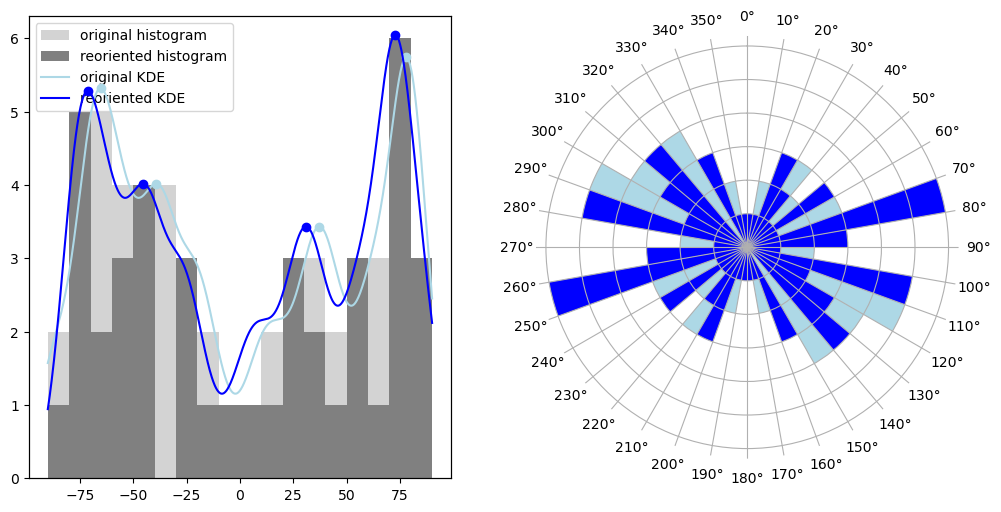

bimodality result:  False




65.87 Ma - 65.83 Ma


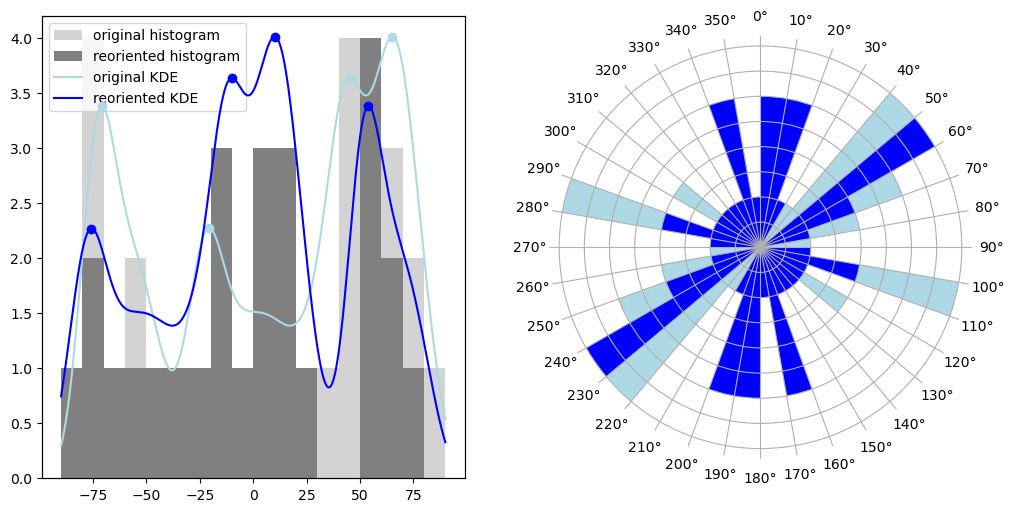

bimodality result:  False




65.83 Ma - 65.79 Ma


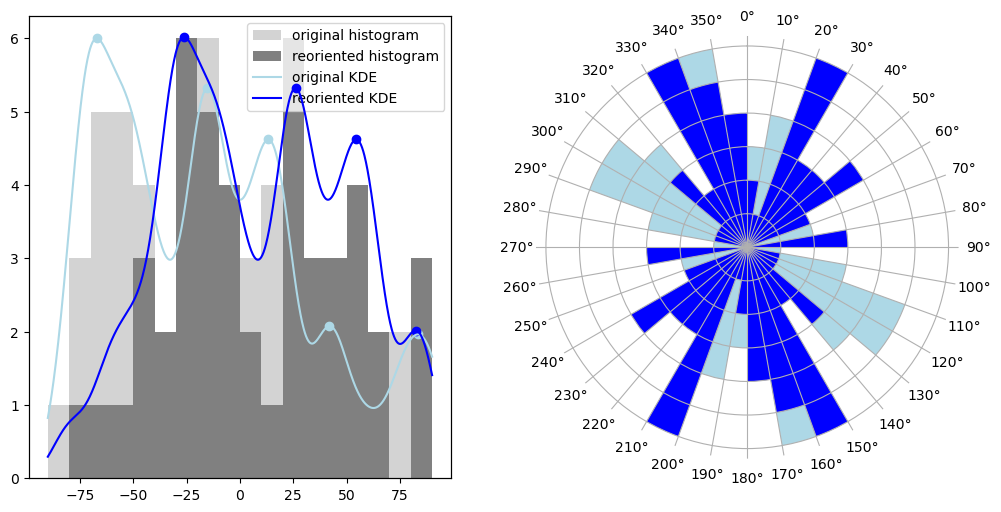

bimodality result:  False




65.79 Ma - 65.75 Ma


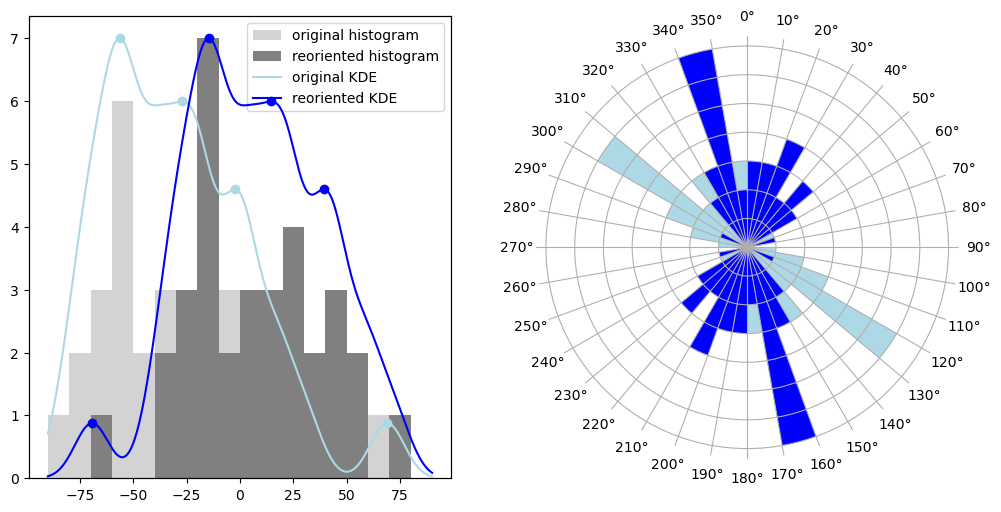

bimodality result:  False




65.75 Ma - 65.72 Ma


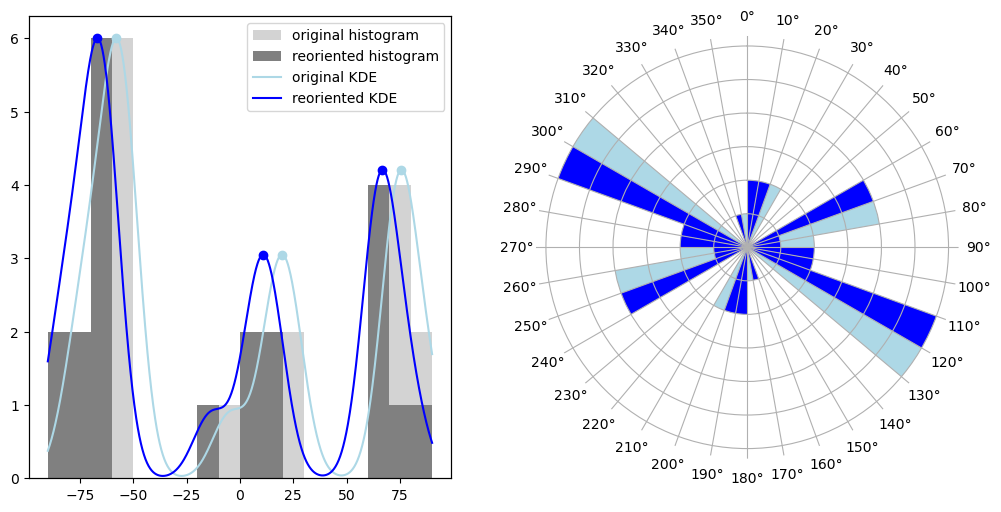

bimodality result:  False




65.72 Ma - 65.64 Ma


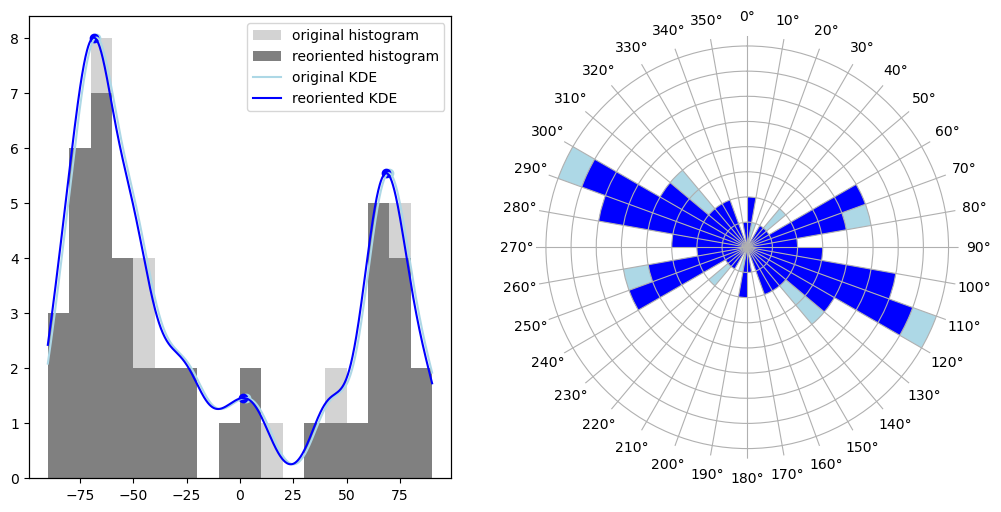

bimodality result:  True




65.64 Ma - 65.56 Ma


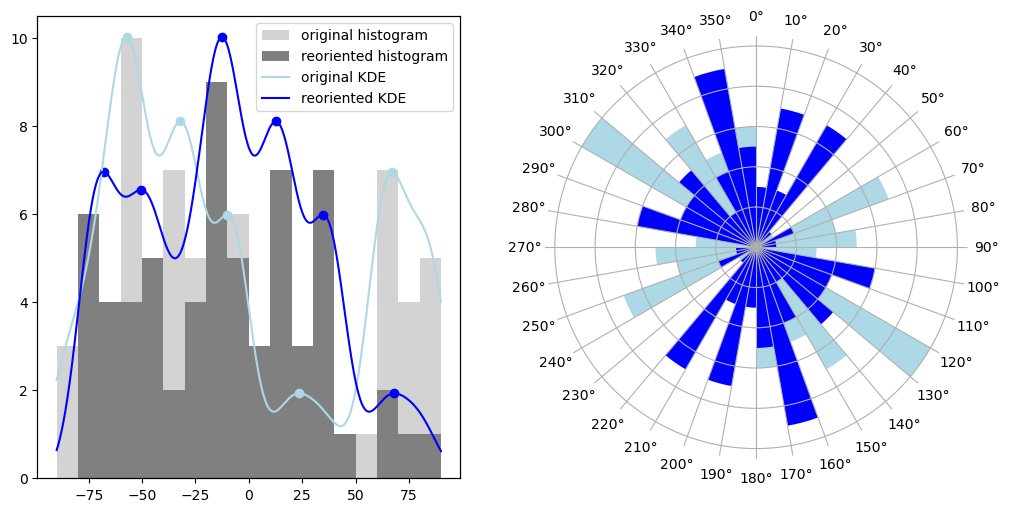

bimodality result:  False




65.56 Ma - 65.47 Ma


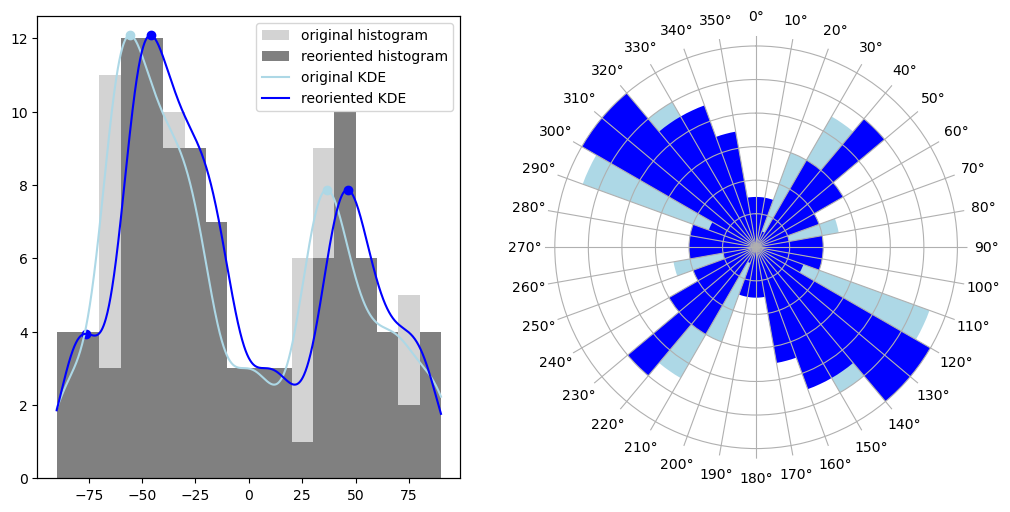

bimodality result:  True




65.47 Ma - 65.36 Ma


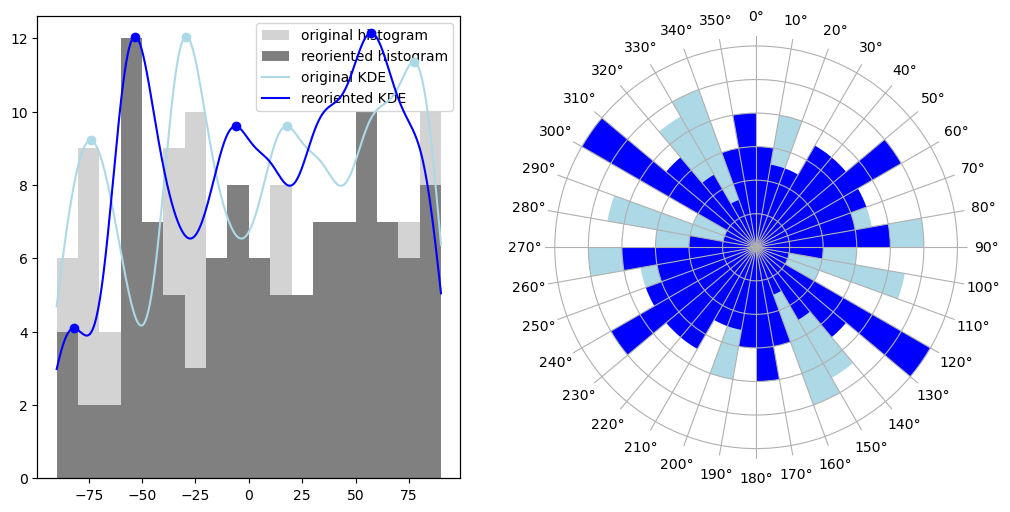

bimodality result:  False




65.36 Ma - 65.24 Ma


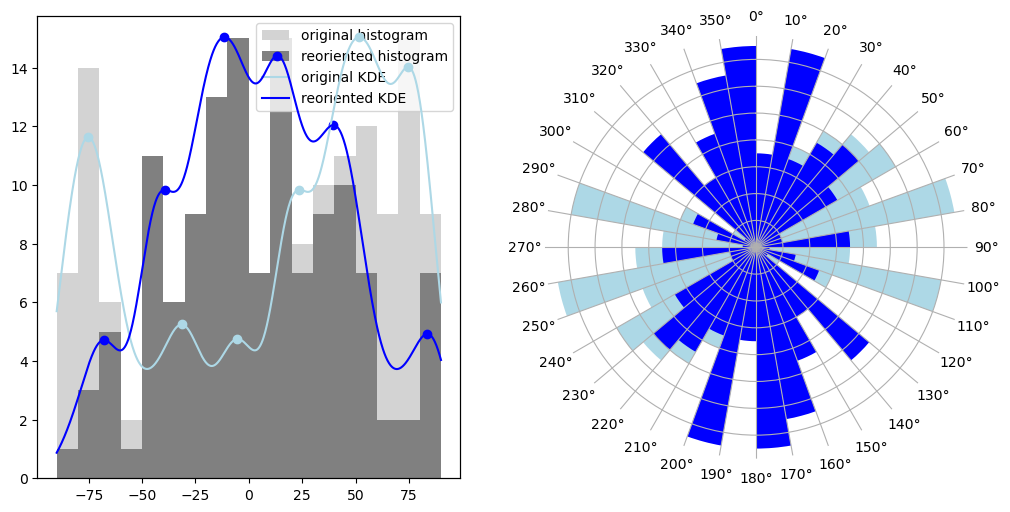

bimodality result:  False




65.24 Ma - 65.15 Ma


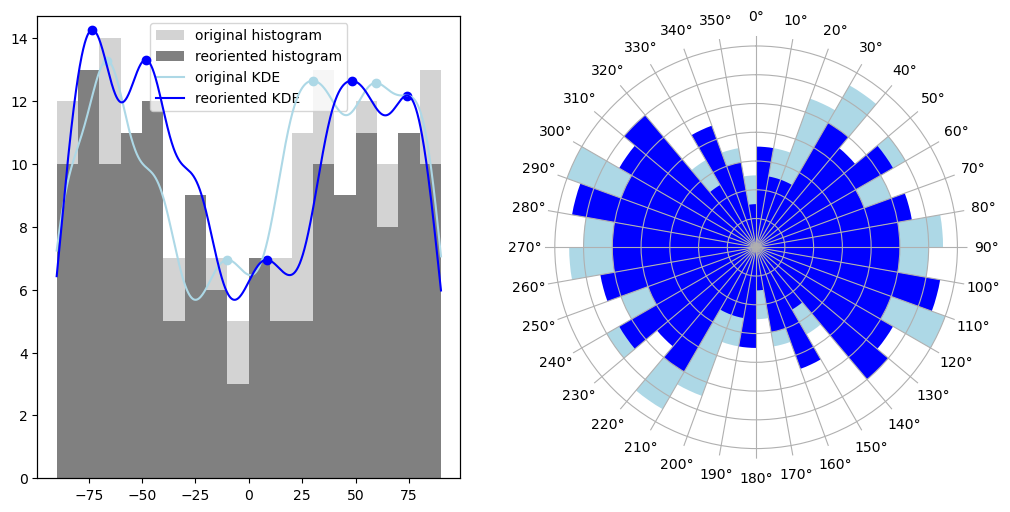

bimodality result:  False




65.15 Ma - 65.05 Ma


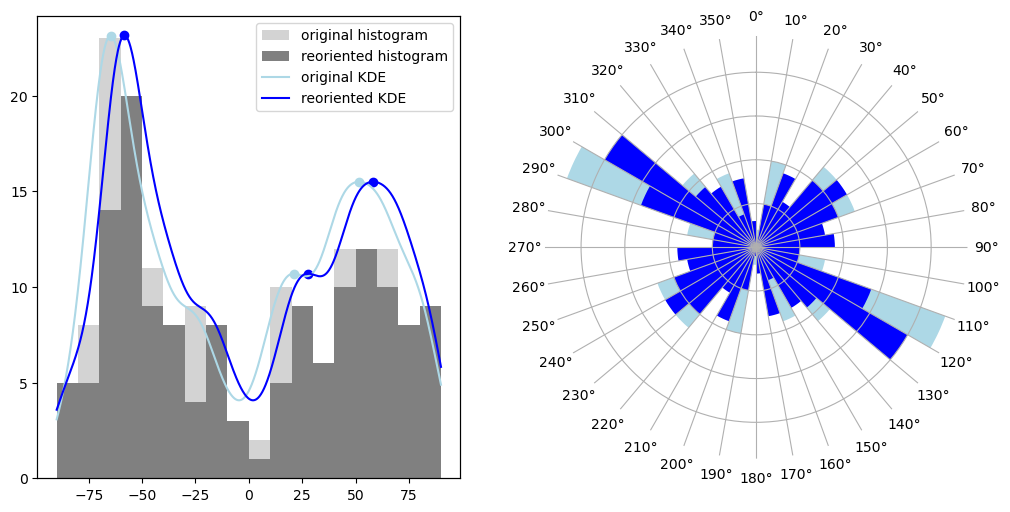

bimodality result:  False




65.05 Ma - 64.96 Ma


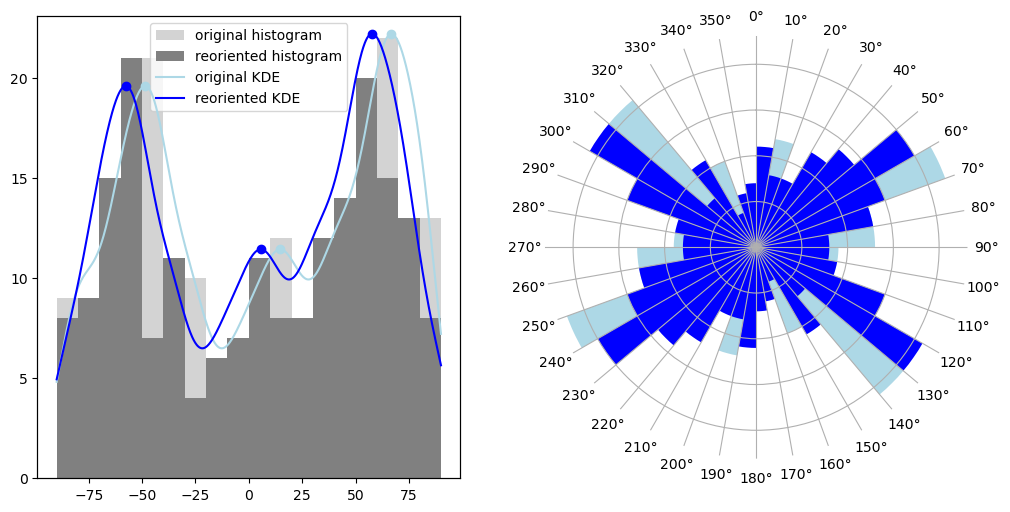

bimodality result:  False




64.96 Ma - 64.86 Ma


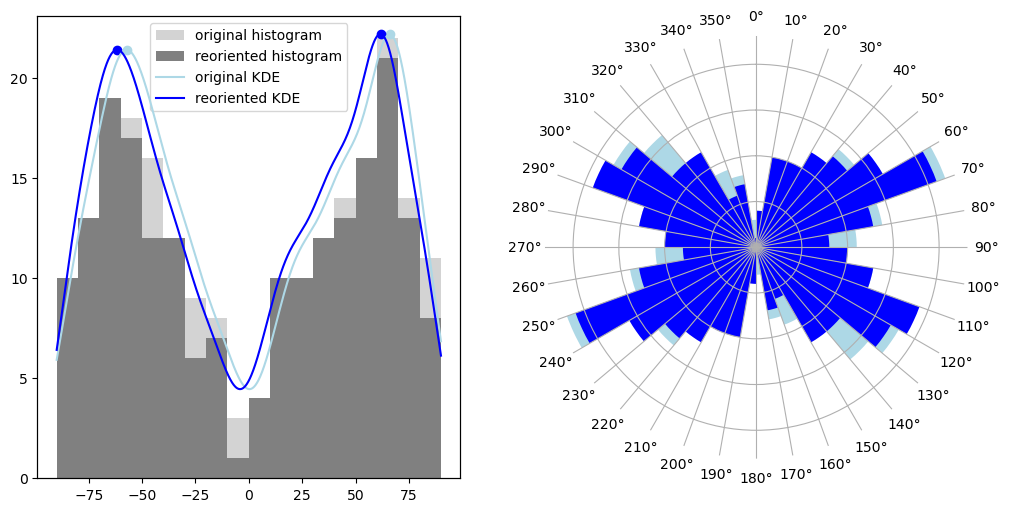

bimodality result:  True




64.86 Ma - 64.83 Ma


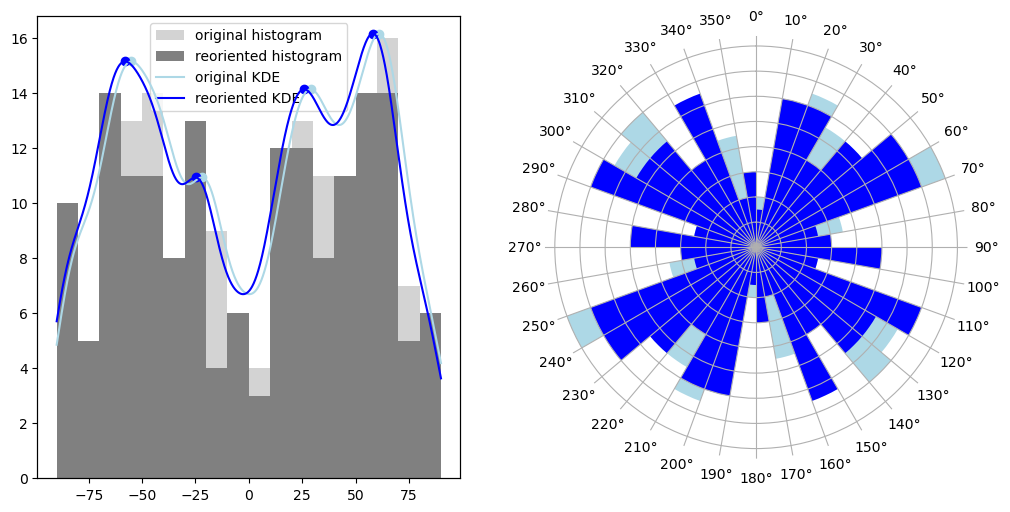

bimodality result:  False




64.83 Ma - 64.79 Ma


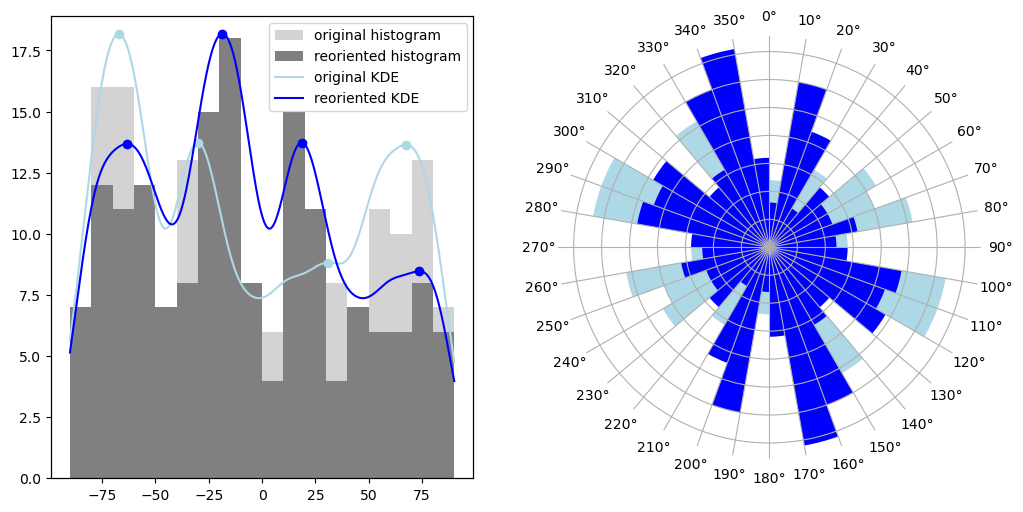

bimodality result:  False




64.79 Ma - 64.73 Ma


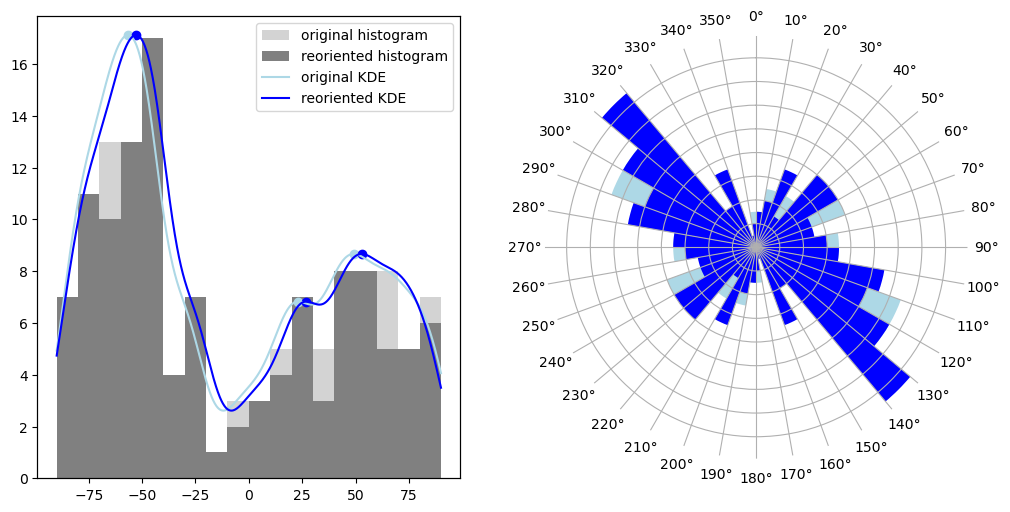

bimodality result:  False




64.73 Ma - 64.67 Ma


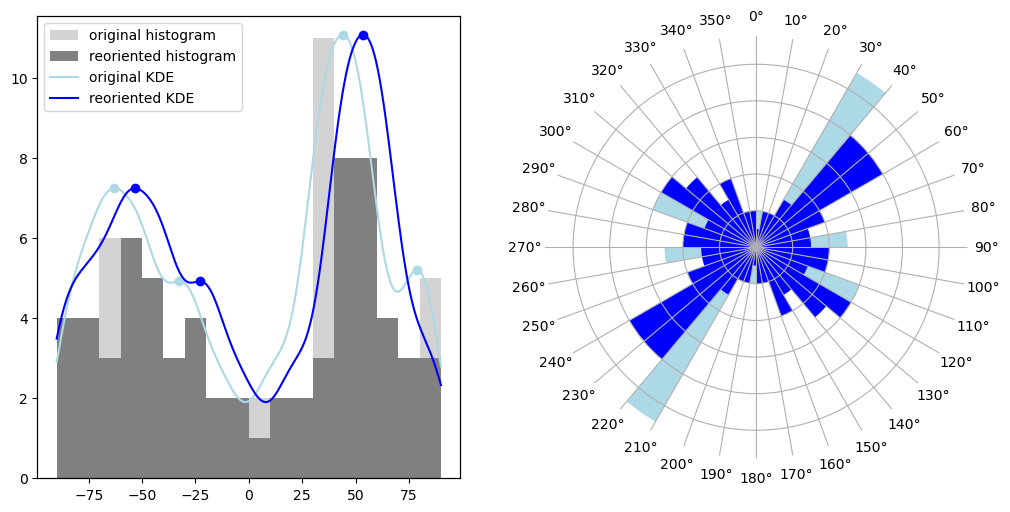

bimodality result:  False




64.67 Ma - 64.61 Ma


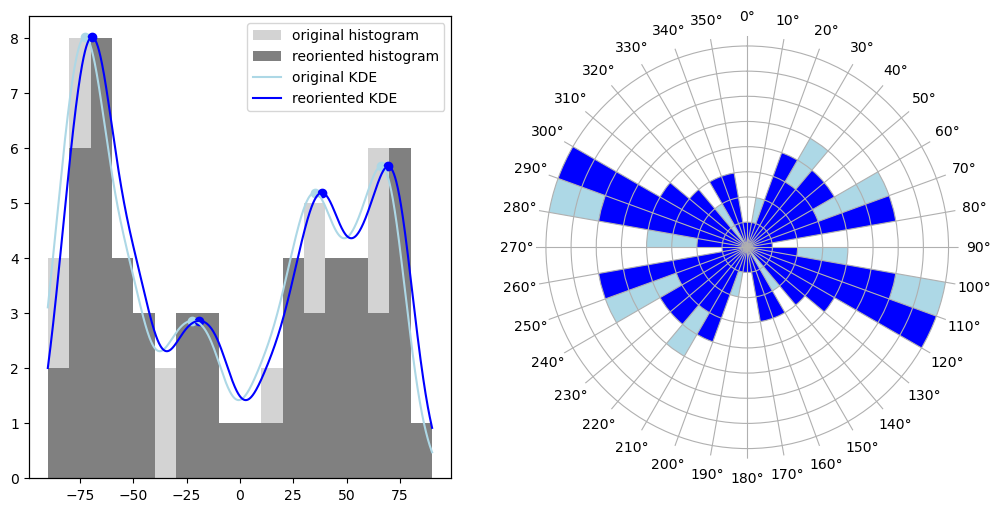

bimodality result:  False




64.61 Ma - 64.55 Ma


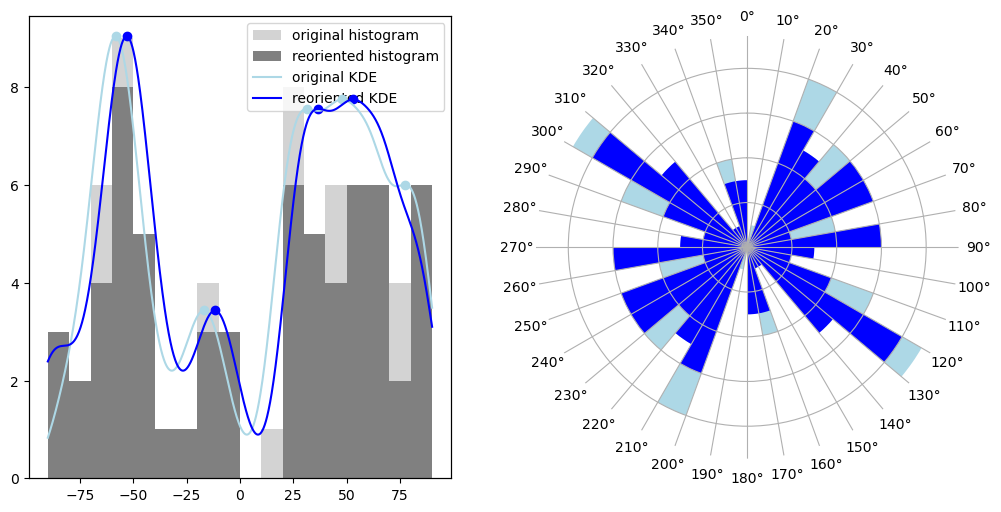

bimodality result:  False




64.55 Ma - 64.50 Ma


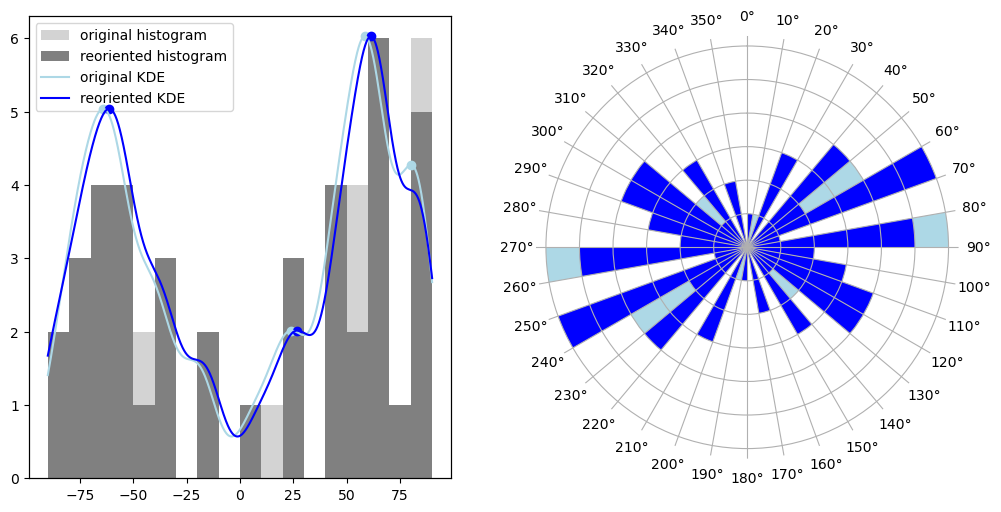

bimodality result:  True




64.50 Ma - 64.44 Ma


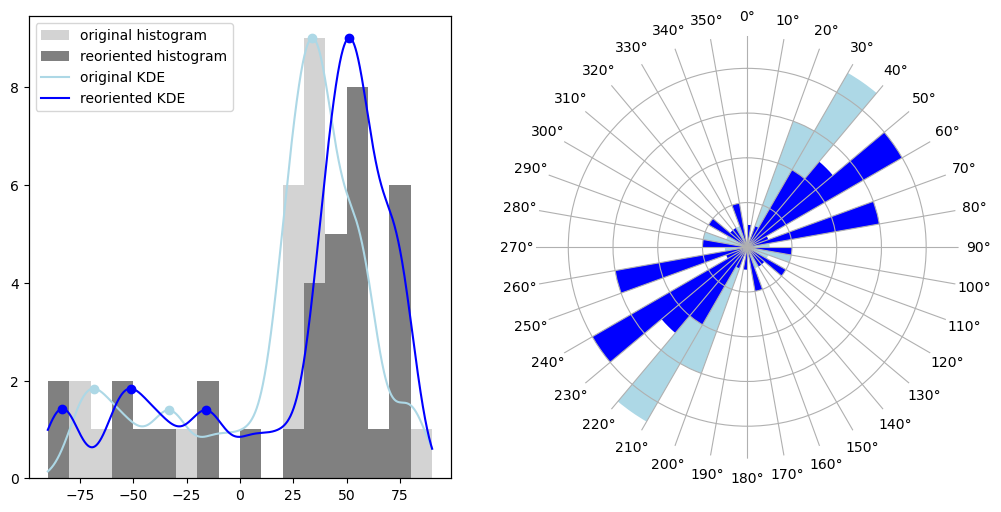

bimodality result:  False




64.44 Ma


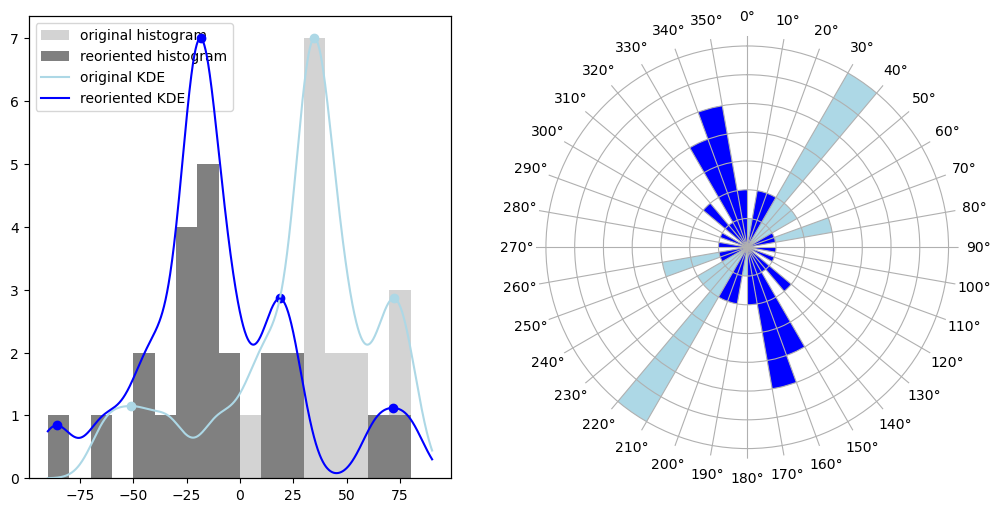

bimodality result:  False






In [16]:
bimodal_results = []

for bin_index in range(len(bins)):
    age_label = f"{rounded_ages[bin_index]:.2f} Ma"  # Get the rounded age for the current bin
    if bin_index < len(bins)-1:
        next_age_label = f"{rounded_ages[bin_index+1]:.2f} Ma"  # Get the rounded age for the current bin
        print(age_label, "-", next_age_label)
    else: 
        print(age_label)
    bin_data = bins[bin_index]
    if bin_data.size > 0:
        angles = transform_angles(bin_data[:, 4])
        if len(angles) >= 10: 
            bimodal, t1, t2 = check_bimodality(angles, bw=8, reorient=True, plot=True)
            print("bimodality result: ", bimodal)
            bimodal_results.append(bimodal)
            print("\n")
        else: 
            print("<10 data points")
    else: 
        print("<10 data points")
    print("\n")